# Analysis of AST4 Tilt

In [154]:
# Import libraries used in this notebook
from datetime import date, datetime
import os

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
# import matplotlib.colormaps

In [3]:
# Load tilt data from local CSVs
tiltpath = "C:\\Users\\kylene.cooley\\Desktop\\AST4 Tilt"
prawler = pd.read_csv(tiltpath+"\\AST4_SWM_Prawler_Tilt_21791784_XYZTiltData_2024-02-12.csv", header=None, skiprows=2, index_col=[0, 1], date_format="%m/%d/%y %I:%M:%S %p")
depressor = pd.read_csv(tiltpath+"\\AST4_SWM_Depressor_Weight_Tilt_21791782_XYZTiltData_2024-02-12.csv", header=None, skiprows=2, index_col=[0, 1], date_format="%m/%d/%y %I:%M:%S %p")

In [4]:
# Change index and column labels in prawler and depressor weight data frames
prawler.reset_index(level=0, drop=True, inplace=True)
prawler.rename_axis(index={1:"date"}, inplace=True)
prawler.rename(columns={2: "x_tilt", 3: "y_tilt", 4:"z_tilt"}, inplace=True)
depressor.reset_index(level=0, drop=True, inplace=True)
depressor.rename_axis(index={1:"date"}, inplace=True)
depressor.rename(columns={2: "x_tilt", 3: "y_tilt", 4:"z_tilt"}, inplace=True)

In [107]:
# Convert data frames to xarray
prawler_xr = xr.Dataset.from_dataframe(prawler).sel(date=slice("23 Oct 2023 18:00:00","8 Feb 2024 13:00:00"))
depressor_xr = xr.Dataset.from_dataframe(depressor).sel(date=slice("23 Oct 2023 18:00:00","8 Feb 2024 13:00:00"))

In [6]:
# prawler_xr
# depressor_xr

In [108]:
x_prawler = prawler_xr["x_tilt"]
x_depress = depressor_xr["x_tilt"]

In [109]:
x_prawler

<xarray.DataArray 'x_tilt' (date: 15523)>
array([157.7, 167.2, 167.2, ..., 157.7, 157.7, 154.2])
Coordinates:
  * date     (date) datetime64[ns] 2023-10-23T18:00:00 ... 2024-02-08T13:00:00

In [111]:
# Compare mean tilt of prawler to mean tilt of depressor weight
prawler_mean = x_prawler.mean()
depress_mean = x_depress.mean()

In [112]:
# Check percentage of prawler x-tilt data with tilts less than 30 deg and 45 deg from vertical
prawler_percent30 = 100*(x_prawler.where(x_prawler>150).count()/len(x_prawler))
prawler_percent45 = 100*(x_prawler.where(x_prawler>135).count()/len(x_prawler))

In [113]:
# Check percentage of depressor weight x-tilt with tilts less than 30 deg and 45 deg from vertical
depress_percent30 = 100*(x_depress.where(x_depress>150).count()/len(x_depress))
depress_percent45 = 100*(x_depress.where(x_depress>135).count()/len(x_depress))
# I wouldn't expect these percentages of small-angle measurements for the depressor weight compared 
# to the prawler bc the depressor weight tilt sensor could pivot. 
# I expected this to have more measurements of small tilt angles (>150) bc the pivot point would allow 
# it to remain more vertical than the depressor weight exterior.

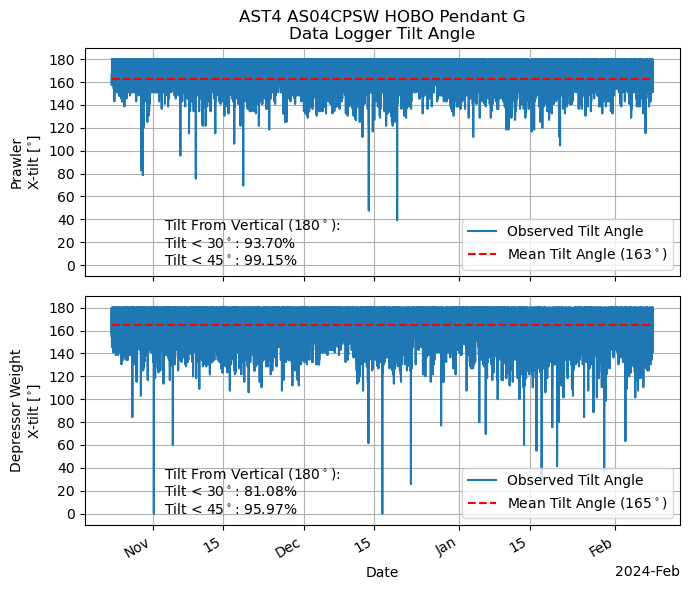

In [114]:
# Nicer plot of full timeseries from both sensors (than HOBOware plot)
fig, axs = plt.subplots(2, 1, figsize=(7,6), sharex=True, layout="tight")
x_prawler.plot(ax=axs[0], label="Observed Tilt Angle")
axs[0].set(ylabel="Prawler\nX-tilt [$^{\circ}$]", ylim=(-10, 190), yticks=np.linspace(0, 180, 10), xlabel="")
axs[0].text(x=x_prawler.date[1500], y=0,
         s=f"Tilt From Vertical (180$^\circ$):\nTilt < 30$^\circ$: {prawler_percent30:.2f}%\nTilt < 45$^\circ$: {prawler_percent45:.2f}% ",
         )
axs[0].hlines(prawler_mean, x_prawler.date[0], x_prawler.date[-1], colors="red", linestyles="dashed", label=f"Mean Tilt Angle ({prawler_mean:.0f}$^\circ$)")
axs[0].legend(loc="lower right")
x_depress.plot(ax=axs[1], label="Observed Tilt Angle")
axs[1].set(ylabel="Depressor Weight\nX-tilt [$^{\circ}$]", xlabel="Date", ylim=(-10, 190), yticks=np.linspace(0, 180, 10))
axs[1].text(x=x_depress.date[1500], y=0,
         s=f"Tilt From Vertical (180$^\circ$):\nTilt < 30$^\circ$: {depress_percent30:.2f}%\nTilt < 45$^\circ$: {depress_percent45:.2f}% ",
         )
axs[1].hlines(depress_mean, x_depress.date[0], x_depress.date[-1], colors="red", linestyles="dashed", label=f"Mean Tilt Angle ({depress_mean:.0f}$^\circ$)")
axs[1].legend(loc="lower right")
axs[0].set_title("AST4 AS04CPSW HOBO Pendant G\nData Logger Tilt Angle")
axs[0].grid()
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))
axs[1].grid()
plt.show()

In [115]:
# Save full time series figure
fig.savefig(tiltpath+"\\AS04CPSW_tilt_full_timeseries_{now}.png".format(now=datetime.now().strftime('%Y%m%dT%H%M%S')))

In [116]:
# Save Xarray Datasets to NetCDF files
prawler_xr.to_netcdf("/".join([tiltpath, "AS04CPSW_Prawler_Tilt_{now}.nc".format(now=datetime.now().strftime('%Y%m%dT%H%M%S'))]), mode="w")
depressor_xr.to_netcdf("/".join([tiltpath, "AS04CPSW_Depressor_Weight_Tilt_{now}.nc".format(now=datetime.now().strftime('%Y%m%dT%H%M%S'))]), mode="w")

In [117]:
# Make shorter time series for 23-24 Oct 2023 of x-tilt data (calm conditions)
x_prawl_calm = x_prawler.sel(date=slice("23 Oct 2023", "24 Oct 2023"))
x_depress_calm = x_depress.sel(date=slice("23 Oct 2023", "24 Oct 2023"))
prawl_calm = prawler_xr.sel(date=slice("23 Oct 2023", "24 Oct 2023"))
depress_calm = depressor_xr.sel(date=slice("23 Oct 2023", "24 Oct 2023"))

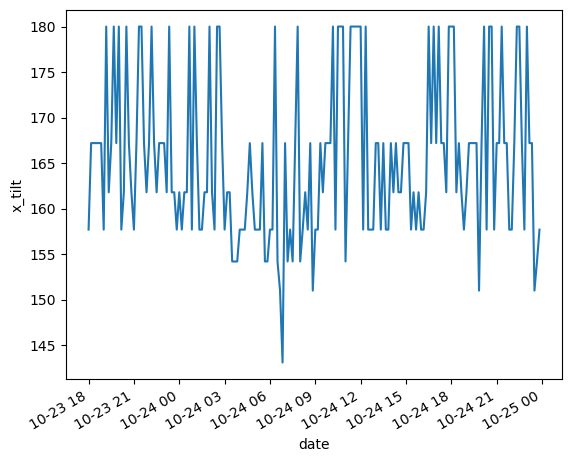

In [118]:
x_prawl_calm.plot()

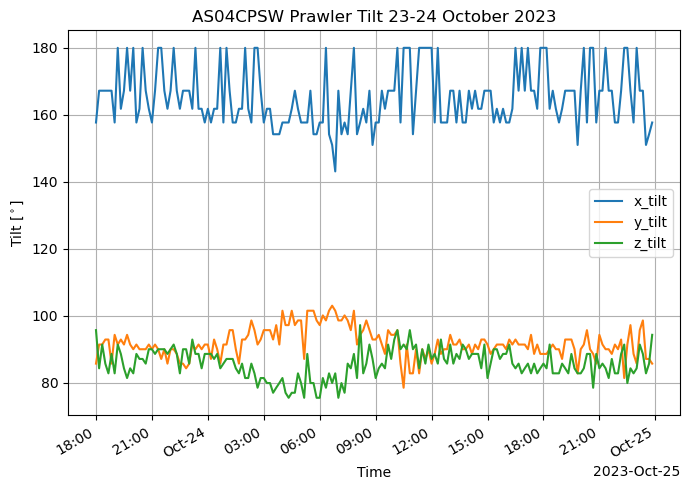

In [122]:
# Plot all three tilt variables for first 2 days of deployment
fig, ax = plt.subplots(1, 1, figsize=(7,5), layout="tight")
for variable in prawl_calm:
    prawl_calm[variable].plot(label=variable)
plt.legend()
plt.ylabel("Tilt [$^\circ$]")
plt.xlabel("Time")
plt.grid()
plt.title("AS04CPSW Prawler Tilt 23-24 October 2023")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.show()

In [120]:
# Save figure to AST4 tilt project folder
fig.savefig(tiltpath+"\\AS04CPSW_Prawler_tilt_23-24Oct2023_{now}.png".format(now=datetime.now().strftime('%Y%m%dT%H%M%S')))

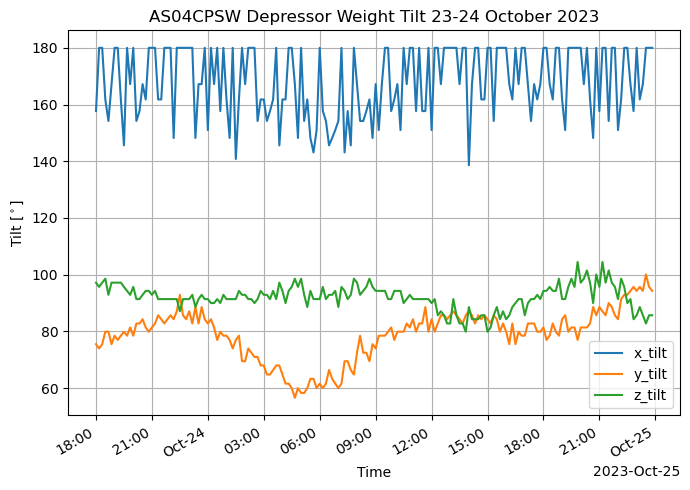

In [175]:
# Same figure for Depressor Weight - plot all three tilt variables for first 2 days of deployment
fig, ax = plt.subplots(1, 1, figsize=(7,5), layout="tight")
for variable in depress_calm:
    depress_calm[variable].plot(label=variable)
plt.legend()
plt.ylabel("Tilt [$^\circ$]")
plt.xlabel("Time")
plt.grid()
plt.title("AS04CPSW Depressor Weight Tilt 23-24 October 2023")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.show()

In [176]:
# Save figure to AST4 tilt project folder
fig.savefig(tiltpath+"\\AS04CPSW_Depressor_Weight_tilt_23-24Oct2023_{now}.png".format(now=datetime.now().strftime('%Y%m%dT%H%M%S')))

In [124]:
# Now we do the same for the storm conditions on 18-19 Dec 2023
prawl_storm = prawler_xr.sel(date=slice("18 Dec 2023", "19 Dec 2023"))
depress_storm = depressor_xr.sel(date=slice("18 Dec 2023", "19 Dec 2023"))

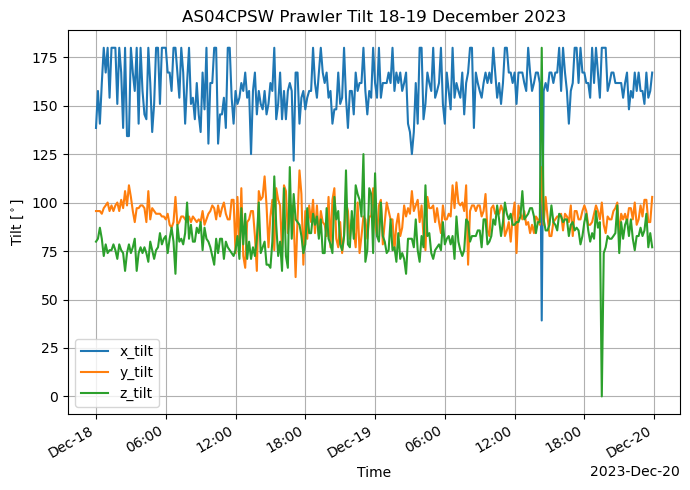

In [55]:
# Plot all three tilt variables for storm days from Prawler
fig, ax = plt.subplots(1, 1, figsize=(7,5), layout="tight")
for variable in prawl_storm:
    prawl_storm[variable].plot(label=variable)
plt.legend()
plt.ylabel("Tilt [$^\circ$]")
plt.xlabel("Time")
plt.grid()
plt.title("AS04CPSW Prawler Tilt 18-19 December 2023")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.show()

In [56]:
# Save figure to AST4 tilt project folder
fig.savefig(tiltpath+"\\AS04CPSW_Prawler_tilt_18-19Dec2023_{now}.png".format(now=datetime.now().strftime('%Y%m%dT%H%M%S')))

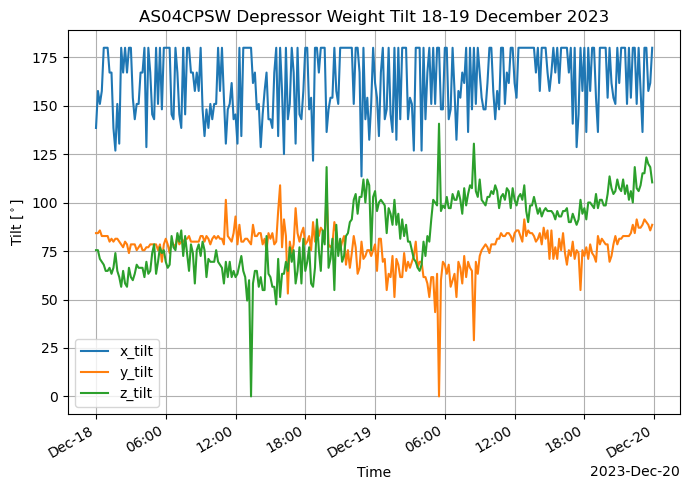

In [57]:
# Same figure for Depressor Weight - plot all three tilt variables for first 2 days of deployment
fig, ax = plt.subplots(1, 1, figsize=(7,5), layout="tight")
for variable in depress_storm:
    depress_storm[variable].plot(label=variable)
plt.legend()
plt.ylabel("Tilt [$^\circ$]")
plt.xlabel("Time")
plt.grid()
plt.title("AS04CPSW Depressor Weight Tilt 18-19 December 2023")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.show()

In [58]:
# Save figure to AST4 tilt project folder
fig.savefig(tiltpath+"\\AS04CPSW_Depressor_Weight_tilt_18-19Dec2023_{now}.png".format(now=datetime.now().strftime('%Y%m%dT%H%M%S')))

In [62]:
# Import Prawler pressure data to check tilt during profiles (pressure in mbar, temp in degC)
prawl_pres = pd.read_csv(tiltpath+"\\AST4_SWM_Prawler_Pressure_Pod_21514526_Pressure_Temp_Data_2024-02-12.csv", header=None, skiprows=2, index_col=[0, 1], date_format="%m/%d/%y %I:%M:%S %p")
prawl_pres.reset_index(level=0, drop=True, inplace=True)
prawl_pres.rename_axis(index={1:"date"}, inplace=True)
prawl_pres.rename(columns={2: "pressure", 3: "temperature"}, inplace=True)

In [125]:
# Convert data frame to a dataset object and grab subset for calm days
prawl_pres_calm = xr.Dataset.from_dataframe(prawl_pres).sel(date=slice("23 Oct 2023 18:00:00", "24 Oct 2023"))

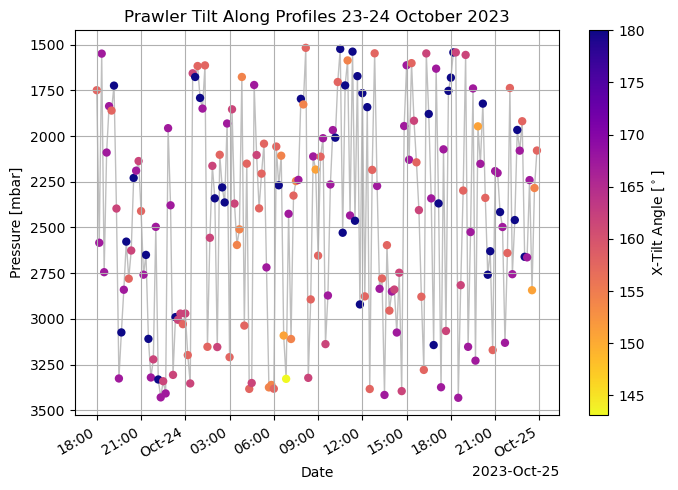

In [174]:
# Plot pressure as a function of time with color as a function of tilt angle
# With a colorbar that goes from light to dark, so that greater tilts are lighter colors
fig, ax = plt.subplots(1, 1, layout="tight", figsize=(7,5))
line = prawl_pres_calm["pressure"].plot(color="gray", zorder=-1, linewidth=1, alpha=0.5)
plt.scatter(prawl_pres_calm["date"], prawl_pres_calm["pressure"], c=prawl_calm["x_tilt"].values, cmap=plt.cm.plasma_r, edgecolors="none")
plt.colorbar(label="X-Tilt Angle [$^\circ$]")
ax.invert_yaxis()
ax.set(ylabel="Pressure [mbar]", xlabel="Date", title="Prawler Tilt Along Profiles 23-24 October 2023")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.grid()
plt.show()

In [170]:
# Save figure to AST4 tilt project folder
fig.savefig(tiltpath+"\\AS04CPSW_Prawler_profile_tilt_23-24Oct2023_{now}.png".format(now=datetime.now().strftime('%Y%m%dT%H%M%S')))

In [141]:
# Import GPS data to check both tilt angles in comparison to buoy position
gps = pd.read_csv(tiltpath+"\\AS04CPSW_GPS_Data.csv", date_format="%Y-%m-%d %H:%M:%S.%f", usecols=[1, 2, 3], index_col=2)
gps_xr = xr.Dataset.from_dataframe(gps).sel(Datetime=slice("23 Oct 2023 18:00:00","8 Feb 2024 13:00:00"))

In [142]:
gps_xr

<xarray.Dataset>
Dimensions:    (Datetime: 53108)
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 2023-10-23T18:01:40.468000 ... 2024-...
Data variables:
    Latitude   (Datetime) float64 41.13 41.13 41.13 41.13 ... 41.13 41.13 41.13
    Longitude  (Datetime) float64 -70.95 -70.95 -70.95 ... -70.95 -70.95 -70.95

In [145]:
gps_neardepress = gps_xr.sel(Datetime=depressor_xr["date"], method="nearest")
gps_neardepress

<xarray.Dataset>
Dimensions:    (date: 15523)
Coordinates:
    Datetime   (date) datetime64[ns] 2023-10-23T18:01:40.468000 ... 2024-02-0...
  * date       (date) datetime64[ns] 2023-10-23T18:00:00 ... 2024-02-08T13:00:00
Data variables:
    Latitude   (date) float64 41.13 41.13 41.13 41.13 ... 41.13 41.13 41.13
    Longitude  (date) float64 -70.95 -70.95 -70.95 ... -70.95 -70.95 -70.95

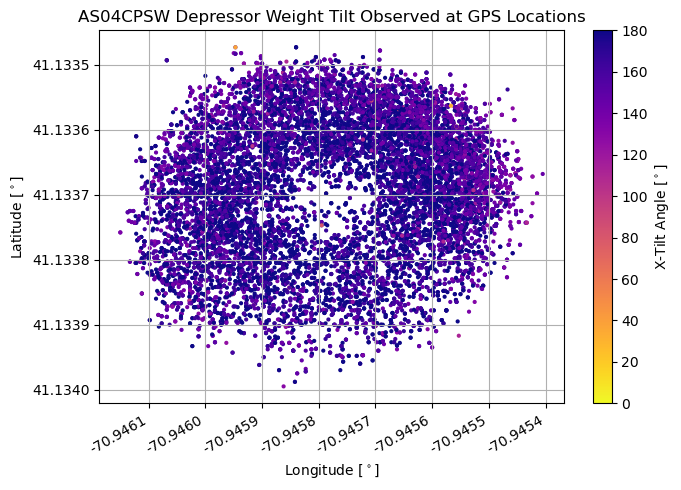

In [171]:
# Plot GPS location on coordinate plane with color as a function of tilt angle
# With a colorbar that goes from light to dark, so that greater tilts are lighter colors
fig, ax = plt.subplots(1, 1, layout="tight", figsize=(7,5))
plt.scatter(gps_neardepress["Longitude"], gps_neardepress["Latitude"], c=depressor_xr["x_tilt"].values, cmap=plt.cm.plasma_r, s=4)
plt.colorbar(label="X-Tilt Angle [$^\circ$]", alpha=1)
ax.invert_yaxis()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set(ylabel="Latitude [$^\circ$]", xlabel="Longitude [$^\circ$]", title="AS04CPSW Depressor Weight Tilt Observed at GPS Locations")
# ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.grid()
plt.show()

In [172]:
# Save figure to AST4 tilt project folder
fig.savefig(tiltpath+"\\AS04CPSW_Depressor_Weight_GPS_tilt_{now}.png".format(now=datetime.now().strftime('%Y%m%dT%H%M%S')))